### Bibliotecas

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import os
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
import lightgbm as lgb
import xgboost as xgb

from scipy import stats
import itertools

from copy import deepcopy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Lendo Dados

In [13]:
df = pd.read_csv('./Data/volve_preproc.csv')
df.shape

(23733, 10)

#### Filtering Data

In [14]:
n=3
df2 = df[::n]
df2.shape

(7911, 10)

In [15]:
df_filt = df2.dropna()
df_filt.shape

(1773, 10)

In [16]:
df.groupby('wellName').count()

,MD,CALI,DT,GR,NPHI,RHOB,PHIF,SW,RACEHM_LOG
wellName,,,,,,,,,
15/9-F-1 A,2099,2099,2099,2099,2099,2099,2099,2099,2099
15/9-F-1 B,1903,1903,1903,1903,1903,1903,1903,1903,1903
15/9-F-1 C,7631,7631,0,7631,7631,7631,7630,7630,7631
15/9-F-11 A,1402,1402,1402,1402,1402,1402,1321,1321,1402
15/9-F-11 B,10698,10698,0,10698,10698,10698,10698,10698,10698


In [17]:
df2.groupby('wellName').count()

,MD,CALI,DT,GR,NPHI,RHOB,PHIF,SW,RACEHM_LOG
wellName,,,,,,,,,
15/9-F-1 A,700,700,700,700,700,700,700,700,700
15/9-F-1 B,634,634,634,634,634,634,634,634,634
15/9-F-1 C,2544,2544,0,2544,2544,2544,2543,2543,2544
15/9-F-11 A,467,467,467,467,467,467,439,439,467
15/9-F-11 B,3566,3566,0,3566,3566,3566,3566,3566,3566


In [18]:
df_filt.groupby('wellName').count()

,MD,CALI,DT,GR,NPHI,RHOB,PHIF,SW,RACEHM_LOG
wellName,,,,,,,,,
15/9-F-1 A,700,700,700,700,700,700,700,700,700
15/9-F-1 B,634,634,634,634,634,634,634,634,634
15/9-F-11 A,439,439,439,439,439,439,439,439,439


### Treinando modelo de ML para prever DT

#### Definindo a parcela de treino e de teste

In [19]:
training_wells = ['15/9-F-11 A', '15/9-F-1 A']
test_wells = ['15/9-F-1 B']
nodata_wells = ['15/9-F-11 B', '15/9-F-1 C'] #poços sem a informação de DT

In [20]:
train_df = df_filt[df_filt['wellName'].isin(training_wells)]
test_df = df_filt[df_filt['wellName'].isin(test_wells)]
nodata_df = df_filt[df_filt['wellName'].isin(nodata_wells)]

#### Selecionando variáveis de entrada e saída

In [21]:
inputs = [
    # 'CALI',
    'DT',
    'GR',
    'NPHI',
    'RHOB',
    'PHIF',
    # 'SW',
    'RACEHM_LOG'
    ]

output = ['SW']

In [22]:
X_tr = train_df[inputs]
y_tr = train_df[output]
X_tr.columns, y_tr.columns

(Index(['DT', 'GR', 'NPHI', 'RHOB', 'PHIF', 'RACEHM_LOG'], dtype='object'),
 Index(['SW'], dtype='object'))

In [23]:
X_te = test_df[inputs]
y_te = test_df[output]
X_te.columns, y_te.columns

(Index(['DT', 'GR', 'NPHI', 'RHOB', 'PHIF', 'RACEHM_LOG'], dtype='object'),
 Index(['SW'], dtype='object'))

In [24]:
X_tr.shape,y_tr.shape,X_te.shape,y_te.shape

((1139, 6), (1139, 1), (634, 6), (634, 1))

In [25]:
X_tr = X_tr.values
X_te = X_te.values
y_tr = y_tr.values
y_te = y_te.values

#### Normalizando dados MinMax

In [26]:
Xtr_scaler = MinMaxScaler()
ytr_scaler = MinMaxScaler()
Xte_scaler = MinMaxScaler()
yte_scaler = MinMaxScaler()
X_tr = Xtr_scaler.fit_transform(X_tr)
X_te = Xte_scaler.fit_transform(X_te)
y_tr = ytr_scaler.fit_transform(y_tr)
y_te = yte_scaler.fit_transform(y_te)

Random State

In [27]:
rs=48

#### Declarando os Modelos ML

In [28]:
models_ml = [
    ('Linear'   ,'LinReg'              ,      LinearRegression(copy_X=True)), #ARX Equivalet
    ('NonLinear','PolyReg'             ,      Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])), #NARX Equivale)t
    ('NonLinear','SVM'                 ,      SVR(max_iter=-1)),
    ('NonLinear','KNN'                 ,      KNeighborsRegressor()),
    ('NonLinear','MLP'                 ,      MLPRegressor(random_state=rs)),
    ('Ensembles','DecisionTree'        ,      DecisionTreeRegressor(random_state=rs)),
    ('Ensembles','RandomForest'        ,      RandomForestRegressor(random_state=rs)),
    ('Ensembles','GradientBoosting'    ,      GradientBoostingRegressor(random_state=rs)),
    ('Ensembles','ExtraTrees'          ,      ExtraTreesRegressor(random_state=rs)),
    ('Ensembles','AdaBoostRegressor'   ,      AdaBoostRegressor(random_state=rs)),
    ('Ensembles','BaggingRegressor'    ,      BaggingRegressor(random_state=rs)),
    # ('Ensembles','LightGBM'            ,      lgb.LGBMRegressor()),
    ('Ensembles','XGBoost'             ,      xgb.XGBRegressor()),
]


In [29]:
for i, m in enumerate(models_ml):
    print (i, m[2])

0 LinearRegression()
1 Pipeline(steps=[('Poly', PolynomialFeatures()), ('Reg', LinearRegression())])
2 SVR()
3 KNeighborsRegressor()
4 MLPRegressor(random_state=48)
5 DecisionTreeRegressor(random_state=48)
6 RandomForestRegressor(random_state=48)
7 GradientBoostingRegressor(random_state=48)
8 ExtraTreesRegressor(random_state=48)
9 AdaBoostRegressor(random_state=48)
10 BaggingRegressor(random_state=48)
11 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan,

#### Parâmetros (RandomSearchCV)

In [30]:
parameters = [
    { # LinReg 0
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'positive'                     : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # PolyReg NARX 1
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'Reg__positive'                : [True, False],
        #'Poly__degree'                : [2, 3, 4, 5],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # SVM 2
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # KNN 3
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # MLP 6
        'activation'            : ['relu', 'tanh'],
        'early_stopping'        : [True],
        'learning_rate_init'    : stats.loguniform(1e-4, 0.01),
        # 'learning_rate'         : ['adaptive', 'constant'],
        'alpha'                 : stats.loguniform(1e-5, 1e-3),
        'hidden_layer_sizes'    : []
        + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=1)]
        + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=2)]
        + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=3)],
        # + [n_neurons for n_neurons in itertools.product([20, 60, 100], repeat=4)],
        # 'max_iter'              : [10000],#stats.randint(200,10000),
        # 'batch_size'            : [32],
        # 'solver'                : ['adam'], #'lbfgs'],
        'tol'                   : stats.loguniform(1e-7, 1e-1),
    },
    { # DecisionTree 7
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # RandomForest 8
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # GradientBoosting 9
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'loss'                   : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'learning_rate'          : stats.loguniform(1e-5, 1e1),
        'criterion'              : ['friedman_mse', 'squared_error'],
        'subsample'              : stats.uniform(),
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # ExtraTrees 10
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'criterion'              : ['squared_error', 'absolute_error'],
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # AdaBoostRegressor 11
        'n_estimators'              : stats.randint(5,100), #Numero de arvores
        'learning_rate'             : stats.loguniform(1e-3, 10),
        'loss'                      : ['linear', 'square', 'exponential'],
    },
    { # BaggingRegressor 12
        'n_estimators'              : stats.randint(5,100), #Numero de arvores
        'max_samples'               : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_features'              : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'bootstrap'                 : [True, False],      #maxima quantidade de features para embasar a decisao de divisao
    },
    # { # LightGBM 13
    #     'num_leaves'                : stats.randint(5,100), # max num folhas dos base learners
    #     'n_estimators'              : stats.randint(10,200), #Numero de arvores
    #     'learning_rate'             : stats.loguniform(1e-3, 1),
    #     # 'max_depth'                 : stats.randint(1,20), #maxima profundidade da arvore
    # },
    { # XGBoost 14
        'n_estimators'           : stats.randint(2,100), #Numero de arvores
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'learning_rate'          : stats.loguniform(1e-3, 1),
    },
]
# parameters

In [31]:
kfolds = 5
niters = 10
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=rs)
rkf

RepeatedKFold(n_repeats=10, n_splits=5, random_state=48)

#### Random Search

In [32]:
n_iter = 100 #Numero de iterações do rdmsearch
models=[]
for model, params in zip(models_ml, parameters):
    rdmsearch = RandomizedSearchCV(model[2], verbose=0, scoring='r2',
                                   param_distributions=params, n_iter=n_iter, n_jobs=6,
                                   cv=rkf, random_state=rs)

    models.append(
        # (model[0], model[1], rdmsearch)
        (model[1], model[2], rdmsearch, model[0])
    )

models

[('LinReg',
  LinearRegression(),
  RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=48),
                     estimator=LinearRegression(), n_iter=100, n_jobs=6,
                     param_distributions={'positive': [True, False]},
                     random_state=48, scoring='r2'),
  'Linear'),
 ('PolyReg',
  Pipeline(steps=[('Poly', PolynomialFeatures()), ('Reg', LinearRegression())]),
  RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=48),
                     estimator=Pipeline(steps=[('Poly', PolynomialFeatures()),
                                               ('Reg', LinearRegression())]),
                     n_iter=100, n_jobs=6,
                     param_distributions={'Reg__positive': [True, False]},
                     random_state=48, scoring='r2'),
  'NonLinear'),
 ('SVM',
  SVR(),
  RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=48),
                     estimator=SVR(), n_iter=100, n_job

#### Looping de Treinamento

In [34]:
res_dict = {
    'MODEL':[],
    'R2_TR':[],
    'R2_TE':[],
    'MAE_TR':[],
    'MAE_TE':[],
    'MODEL_OBJ':[],
}

base_estimators_lin_nonLin = []
base_estimators = []

best_r2 = 0
t00 = datetime.now()
for model in models:
    t0 = datetime.now()
    model_name, model_estim, model_instance, model_class = model
    print(f'{model_name}  ',end='')

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    model_instance.fit(X=X_tr, y=y_tr);

    y_hat_tr = model_instance.predict(X_tr)
    y_hat_te = model_instance.predict(X_te)
    r2_tr = r2_score(y_tr, y_hat_tr)
    r2_te = r2_score(y_te, y_hat_te)
    mae_tr = mean_absolute_error(y_tr, y_hat_tr)
    mae_te = mean_absolute_error(y_te, y_hat_te)

    res_dict['MODEL'].append(model_name)
    res_dict['R2_TR'].append(r2_tr)
    res_dict['R2_TE'].append(r2_te)
    res_dict['MAE_TR'].append(mae_tr)
    res_dict['MAE_TE'].append(mae_te)
    res_dict['MODEL_OBJ'].append(deepcopy(model_instance))

    print(f'R2(TR,TE)={r2_tr:.3f}->{r2_te:.3f} / MAE(TR,TE)={mae_tr:.3f}->{mae_te:.3f}', end='')
    if r2_te>best_r2:
        best_r2=r2_te
        print(f'-------------------Best! {best_r2:.2f}')
    else:
        print()

    # stacking select base estimators, lin+nonlin or all
    base_estimators.append((model_name, model_instance.best_estimator_))
    if (model_class in ['Linear','NonLinear']):
        base_estimators_lin_nonLin.append((model_name, model_instance.best_estimator_))


LinReg  R2(TR,TE)=0.926->0.587 / MAE(TR,TE)=0.068->0.182-------------------Best! 0.59
PolyReg  R2(TR,TE)=0.942->0.853 / MAE(TR,TE)=0.056->0.090-------------------Best! 0.85
SVM  R2(TR,TE)=0.948->0.864 / MAE(TR,TE)=0.056->0.093-------------------Best! 0.86
KNN  R2(TR,TE)=1.000->0.929 / MAE(TR,TE)=0.000->0.038-------------------Best! 0.93
MLP  R2(TR,TE)=0.957->0.897 / MAE(TR,TE)=0.044->0.078
DecisionTree  R2(TR,TE)=0.972->0.916 / MAE(TR,TE)=0.027->0.053
RandomForest  R2(TR,TE)=0.989->0.948 / MAE(TR,TE)=0.019->0.048-------------------Best! 0.95
GradientBoosting  R2(TR,TE)=0.996->0.953 / MAE(TR,TE)=0.012->0.045-------------------Best! 0.95
ExtraTrees  R2(TR,TE)=0.968->0.943 / MAE(TR,TE)=0.029->0.043
AdaBoostRegressor  R2(TR,TE)=0.937->0.886 / MAE(TR,TE)=0.069->0.086
BaggingRegressor  R2(TR,TE)=0.994->0.930 / MAE(TR,TE)=0.014->0.061
XGBoost  R2(TR,TE)=0.984->0.954 / MAE(TR,TE)=0.025->0.041-------------------Best! 0.95


#### Treinando stacking ensembles

In [37]:
for regi,reg in enumerate(models_ml[:8]):
    print(f'{regi},{reg[1]}')
    rdmsearch_FR = RandomizedSearchCV(reg[2], verbose=0, scoring='r2',
            param_distributions=parameters[regi], n_iter=100, n_jobs=10, cv=rkf, random_state=rs)

    stack1 =  StackingRegressor(estimators=base_estimators_lin_nonLin,final_estimator=rdmsearch_FR,cv='prefit')
    stack2 =  StackingRegressor(estimators=base_estimators,final_estimator=rdmsearch_FR,cv='prefit')

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        stack1.fit(X=X_tr, y=y_tr)
        stack2.fit(X=X_tr, y=y_tr)

    r2_te = r2_score(y_te, stack1.predict(X_te))
    print(f'\tR2(S1)={r2_te:.3f}', end=', ')
    res_dict['MODEL'].append(f'Stack1({reg[1]})')
    res_dict['R2_TR'].append(r2_score(y_tr, stack1.predict(X_tr)))
    res_dict['R2_TE'].append(r2_te)
    res_dict['MAE_TR'].append(mean_absolute_error(y_tr, stack1.predict(X_tr)))
    res_dict['MAE_TE'].append(mean_absolute_error(y_te, stack1.predict(X_te)))
    res_dict['MODEL_OBJ'].append(deepcopy(stack1))

    r2_te = r2_score(y_te, stack2.predict(X_te))
    print(f'R2(S2)={r2_te:.3f}')
    res_dict['MODEL'].append(f'Stack2({reg[1]})')
    res_dict['R2_TR'].append(r2_score(y_tr, stack2.predict(X_tr)))
    res_dict['R2_TE'].append(r2_te)
    res_dict['MAE_TR'].append(mean_absolute_error(y_tr, stack2.predict(X_tr)))
    res_dict['MAE_TE'].append(mean_absolute_error(y_te, stack2.predict(X_te)))
    res_dict['MODEL_OBJ'].append(deepcopy(stack2))

0,LinReg
	R2(S1)=0.929, R2(S2)=0.929
1,PolyReg
	R2(S1)=0.929, R2(S2)=0.929
2,SVM
	R2(S1)=0.931, R2(S2)=0.938
3,KNN
	R2(S1)=0.930, R2(S2)=0.948
4,MLP
	R2(S1)=0.927, R2(S2)=0.938
5,DecisionTree
	R2(S1)=0.930, R2(S2)=0.930
6,RandomForest
	R2(S1)=0.930, R2(S2)=0.932
7,GradientBoosting
	R2(S1)=0.928, R2(S2)=0.935


In [44]:
df_results = pd.DataFrame(res_dict)
df_results = df_results.sort_values('R2_TE', ascending=False).reset_index(drop=True)
df_results['IN'] = '.'.join(inputs)
df_results['OUT'] = output[0]
df_results

,MODEL,R2_TR,R2_TE,MAE_TR,MAE_TE,MODEL_OBJ,IN,OUT
0,XGBoost,0.984357,0.953756,2.450801e-02,0.040509,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,DT.GR.NPHI.RHOB.PHIF.RACEHM_LOG,SW
1,GradientBoosting,0.996003,0.953026,1.184722e-02,0.045091,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,DT.GR.NPHI.RHOB.PHIF.RACEHM_LOG,SW
2,Stack2(KNN),1.000000,0.948089,0.000000e+00,0.035599,"StackingRegressor(cv='prefit',\n ...",DT.GR.NPHI.RHOB.PHIF.RACEHM_LOG,SW
3,RandomForest,0.988635,0.948039,1.904550e-02,0.047638,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,DT.GR.NPHI.RHOB.PHIF.RACEHM_LOG,SW
4,ExtraTrees,0.968329,0.943105,2.940486e-02,0.043471,RandomizedSearchCV(cv=RepeatedKFold(n_repeats=...,DT.GR.NPHI.RHOB.PHIF.RACEHM_LOG,SW
5,Stack2(SVM),0.988453,0.938471,3.059691e-02,0.062788,"StackingRegressor(cv='prefit',\n ...",DT.GR.NPHI.RHOB.PHIF.RACEHM_LOG,SW
6,Stack2(MLP),0.999830,0.937528,2.831085e-03,0.041514,"StackingRegressor(cv='prefit',\n ...",DT.GR.NPHI.RHOB.PHIF.RACEHM_LOG,SW
7,Stack2(GradientBoosting),0.999580,0.934695,3.299205e-03,0.038277,"StackingRegressor(cv='prefit',\n ...",DT.GR.NPHI.RHOB.PHIF.RACEHM_LOG,SW
8,Stack2(RandomForest),0.999989,0.931905,5.134499e-04,0.037616,"StackingRegressor(cv='prefit',\n ...",DT.GR.NPHI.RHOB.PHIF.RACEHM_LOG,SW
9,Stack1(SVM),0.993611,0.931254,1.991416e-02,0.048146,"StackingRegressor(cv='prefit',\n ...",DT.GR.NPHI.RHOB.PHIF.RACEHM_LOG,SW


(0.5, 1.0)

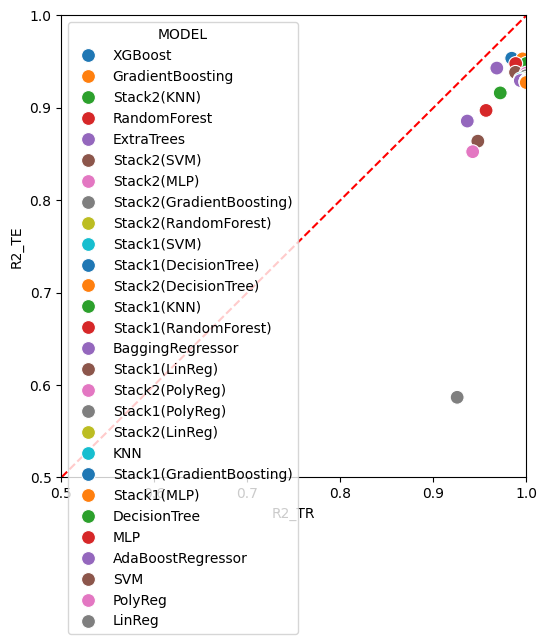

In [45]:
lim = (0.5, 1)
fsize = (6, 6)

plt.figure(figsize=fsize)
sns.scatterplot(data=df_results, y='R2_TE', x='R2_TR', hue='MODEL', s=100, palette='tab10')
plt.plot([0,1],[0,1], 'r--')
plt.xlim(lim)
plt.ylim(lim)

In [46]:
best_model = df_results.loc[0,'MODEL']
y_hat = df_results.loc[0,'MODEL_OBJ'].predict(X_te)

<>:8: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\h'
C:\Users\bewm\AppData\Local\Temp\ipykernel_9048\1924508819.py:8: SyntaxWarning: invalid escape sequence '\h'
  plt.legend(['$y$ - observed','$\hat{y}$ - predictions'])


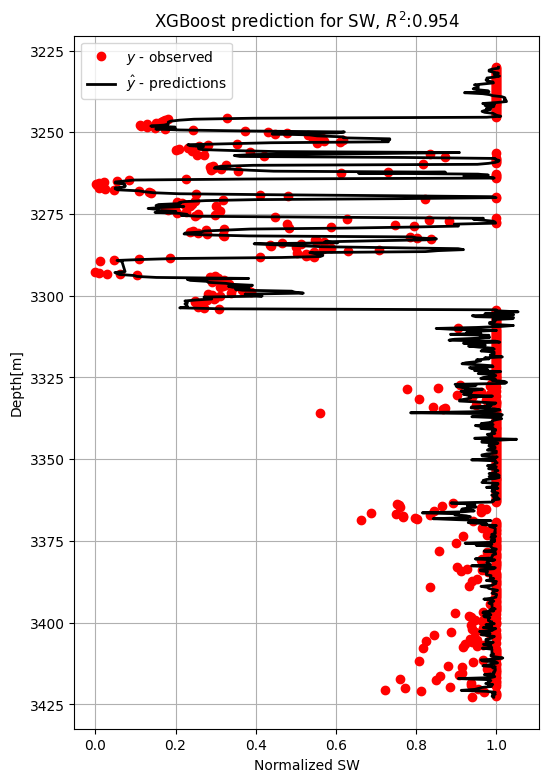

In [47]:
plt.figure(figsize=(6,9))
plt.plot(y_te,test_df['MD'],'ro')
plt.plot(y_hat,test_df['MD'], 'k', lw=2)
plt.gca().invert_yaxis()
plt.title(f'{best_model} prediction for {output[0]}, $R^2$:{r2_score(y_te, y_hat):.3f}')
plt.xlabel(f'Normalized {output[0]}')
plt.ylabel('Depth[m]')
plt.legend(['$y$ - observed','$\hat{y}$ - predictions'])
plt.grid()


<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
C:\Users\bewm\AppData\Local\Temp\ipykernel_9048\1485863182.py:6: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(lim, lim, 'r--', label='$\hat{y}=y$');
C:\Users\bewm\AppData\Local\Temp\ipykernel_9048\1485863182.py:12: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('$\hat{y}$ - predictions')


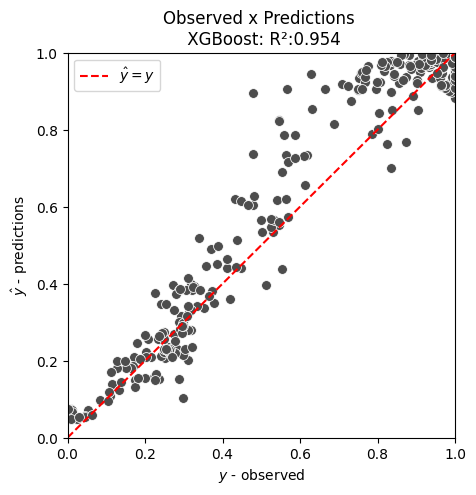

In [55]:
fig = plt.figure(figsize=(5,5))
lim =(0,1)

sns.scatterplot(x=y_te.ravel(), y=y_hat.ravel(), s=50, color='.3');

plt.plot(lim, lim, 'r--', label='$\hat{y}=y$');
plt.xlim(lim)
plt.ylim(lim)

plt.xlabel('$y$ - observed')

plt.ylabel('$\hat{y}$ - predictions')
plt.legend(loc='upper left')

plt.title(f"Observed x Predictions \n {df_results.loc[0,'MODEL']}: R²:{df_results.loc[0,'R2_TE']:.3f}")

# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '7_crossplot_y_yhat.eps')
# fig.savefig(p, format='eps')
pass;

In [57]:
!mkdir Outputs

In [58]:
prefix = 'REG_SW_FILT'
binary = os.path.join(os.getcwd(), 'Outputs', f'{prefix}.pkl')
print(binary)

with open(binary, 'wb') as bin_file:
    pickle.dump(df_results, bin_file)


c:\Users\bewm\2_Projetos\Mestrado\SYSID_well_logs\Outputs\REG_SW_FILT.pkl


#### Estudos dos parametros e tempos de treinamento e param

In [59]:
for i,m in enumerate(df_results['MODEL_OBJ']):
    dfp = m.best_estimator_.get_params()
    print (m.best_estimator_.__class__.__name__, dfp)

XGBRegressor {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.16863740208101174, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 45, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
GradientBoostingRegressor {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'fri

AttributeError: 'StackingRegressor' object has no attribute 'best_estimator_'

In [ ]:
for i,m in enumerate(df_results['MODEL_OBJ']):
    estim_cvr = m.cv_results_
    print (f"{m.best_estimator_.__class__.__name__}:", f"{np.mean(estim_cvr['mean_fit_time'])*1000:.0f} ms")

# for i,m in enumerate(df_rank['MODEL_OBJ']):
# if m.estimator.cv == 'prefit': #stack
#     print (m.estimator.final_estimator_.best_estimator_)
# else: #no stack
#     print (m.estimator.best_estimator_)